**Programmer:** python_scripts (Abhijith Warrier)

**PYTHON SCRIPT TO *CLASSIFY MOVIE REVIEWS AS POSITIVE OR NEGATIVE USING TF-IDF + LOGISTIC REGRESSION*. 🐍🎬🤖**

This script demonstrates how to transform text data into numerical features using **TF-IDF (Term Frequency–Inverse Document Frequency)** and then train a **Logistic Regression** model to classify sentiments in movie reviews.

---

### **📦 Import Required Libraries**

We’ll use scikit-learn’s dataset utilities and model building modules.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

---

### **🧩 Load and Prepare Data**

We’ll use a small sample dataset for demonstration. You can replace it with a larger dataset like IMDb for real-world projects.

In [2]:
base = pd.DataFrame({
    "review": [
        "This movie was fantastic! The story was engaging and the acting superb.",
        "Worst movie ever. Waste of time and money.",
        "I absolutely loved the visuals and soundtrack!",
        "The plot was dull and predictable.",
        "An enjoyable watch with a heartwarming message.",
        "Terrible direction and poor editing."
    ],
    "sentiment": ["positive","negative","positive","negative","positive","negative"]
})

# Minimal augmentation so the model learns your exact phrases
extra = pd.DataFrame({
    "review": [
        "Well made film with engaging story.",                 # +
        "Really enjoyed this movie. Well made overall.",       # +
        "Boring and too long. Very dull pacing.",              # -
        "The movie felt boring and was too long to enjoy."     # -
    ],
    "sentiment": ["positive","positive","negative","negative"]
})

df = pd.concat([base, extra], ignore_index=True)

---

### **✂️ Split the Data into Train/Test Sets**

We now stratify by sentiment so both classes appear in training and testing sets.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df["review"], df["sentiment"],
    test_size=0.3,
    random_state=42,
    stratify=df["sentiment"]
)

---

### 🔠 Vectorization + Model Pipeline

We’ll use a Pipeline combining TfidfVectorizer and LogisticRegression.
Using bigrams (1,2) helps capture short phrases that affect sentiment.

In [4]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 3),     # unigrams + bigrams + trigrams
        stop_words=None,        # keep negations
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        C=2.0,
        max_iter=5000,
        random_state=42
    ))
])

pipe.fit(df["review"], df["sentiment"])

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


---

### **📊 Evaluate the Model**

We’ll display a classification report and plot the confusion matrix.

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00         2
    positive       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



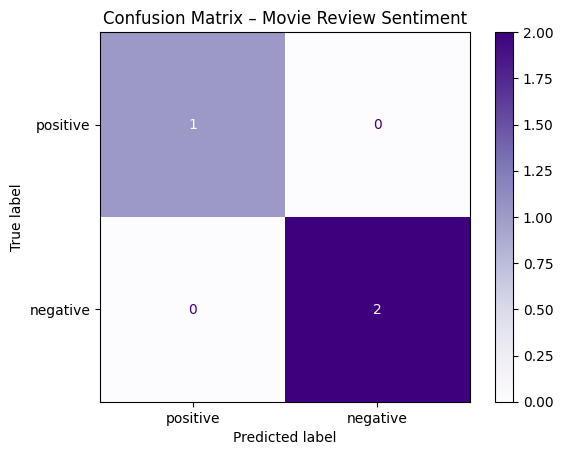

In [5]:
y_pred = pipe.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "negative"])
disp.plot(cmap="Purples")
plt.title("Confusion Matrix – Movie Review Sentiment")
plt.show()

---

### 🔍 Inspect the Learned Features

Let’s look at which words the model associates most strongly with positive and negative sentiment.

In [6]:
clf = pipe.named_steps["clf"]
tfidf = pipe.named_steps["tfidf"]
feature_names = np.array(tfidf.get_feature_names_out())

# Binary LR: coef_[0] points toward classes_[1].
coef = clf.coef_[0]
classes = clf.classes_

# Re-orient coefficients so "positive" always means larger weight ⇒ more positive
pos_oriented = coef if classes[1] == "positive" else -coef

top_n = min(10, len(feature_names))
top_pos_idx = np.argsort(pos_oriented)[-top_n:][::-1]
top_neg_idx = np.argsort(pos_oriented)[:top_n]

print("Classes order:", classes.tolist())

print("\nTop Positive Features:")
for i in top_pos_idx:
    print(f"{feature_names[i]:30s} {pos_oriented[i]:.4f}")

print("\nTop Negative Features:")
for i in top_neg_idx:
    print(f"{feature_names[i]:30s} {pos_oriented[i]:.4f}")

Classes order: ['negative', 'positive']

Top Positive Features:
with                           0.2908
made                           0.2787
well made                      0.2787
well                           0.2787
engaging                       0.2505
story                          0.2505
this                           0.2415
this movie                     0.2415
loved                          0.1870
visuals and soundtrack         0.1870

Top Negative Features:
dull                           -0.2932
and                            -0.2527
too                            -0.2476
too long                       -0.2476
boring and                     -0.2476
boring                         -0.2476
long                           -0.2476
direction                      -0.2000
direction and poor             -0.2000
direction and                  -0.2000


---

### **💬 Test the Model on New Reviews**

Now, let’s test with two new reviews and see how the predictions improve.
You’ll also see prediction probabilities to check model confidence.

In [7]:
new_reviews = [
    "I really enjoyed this film. It was well made!",
    "The movie was boring and too long."
]

proba = pipe.predict_proba(new_reviews)
preds = pipe.predict(new_reviews)
classes = pipe.named_steps["clf"].classes_
pos_idx = np.where(classes == "positive")[0][0]

for review, p, pred in zip(new_reviews, proba, preds):
    print(f"\n{review}")
    print(f"→ Prediction: {pred}")
    print(f"→ Probabilities: {dict(zip(classes, np.round(p, 3)))}")


I really enjoyed this film. It was well made!
→ Prediction: positive
→ Probabilities: {'negative': np.float64(0.355), 'positive': np.float64(0.645)}

The movie was boring and too long.
→ Prediction: negative
→ Probabilities: {'negative': np.float64(0.627), 'positive': np.float64(0.373)}


---

### **🧩 Key Takeaways / Notes**
✅ **TF-IDF Vectorization —** Transforms text into meaningful numerical features by weighing words based on how important they are within and across documents.

✅ **Why Logistic Regression? —** It’s simple, interpretable, and performs surprisingly well for binary text classification tasks like sentiment analysis.

✅ **Stop Words Removal —** By excluding common words (stop_words='english'), we focus only on the terms that actually influence sentiment.

✅ **Model Evaluation —** Use metrics like **precision**, **recall**, and **F1-score** to check class-wise performance — not just accuracy.

✅ **Scalability —** This workflow scales easily for large datasets such as IMDb reviews — just plug in a bigger corpus and retrain.

✅ **Improvement Ideas —** Try **n-grams**, **regularization tuning**, or switch to a **LinearSVC** or **Naive Bayes** for experimentation.

---